### Treasury API Example

The US Treasury API offers data on federal finances. 

https://fiscaldata.treasury.gov/api-documentation/

This example uses the python requests and pandas packages to retrieve treasury data.

In [1]:
import requests
import pandas as pd

Let's look at government revenue by type, from table 9 of the Monthly Treasury Statement (MTS). I want to see the share of federal revenue coming from corporate income taxes and customs duties since 2023.

I'm using the line description from the original MTS table, which has two lines for "Total", one for receipts and one for outlays. I'll need to remove the outlays data in the next step. 

In [2]:
url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service'
endpt = '/v1/accounting/mts/mts_table_9'
param = '?filter=classification_desc:in:(Corporation Income Taxes,Customs Duties,Total)&page[size]=800'

r = requests.get(f'{url}{endpt}{param}')

Next, clean up the results and rename the variables. Remove data related to line 33, which is total outlays. Convert the dates to datetime format and calculate the 12 month rolling sum.

In [3]:
rn = {'current_month_rcpt_outly_amt': 'Value', 'src_line_nbr': 'Line',
      'classification_desc': 'Category'}
df = pd.DataFrame(r.json()['data']).rename(rn, axis=1).query('Line != "33"') # Drop exta data
df['Date'] = pd.to_datetime(df['record_date'])
df = df.sort_index()
df = df.set_index(['Category', 'Date'])
data = (df['Value'].unstack().T.astype('float') / 1_000_000).rolling(12).sum().dropna()

Create a plot showing the recent data, from 2023 onward. 

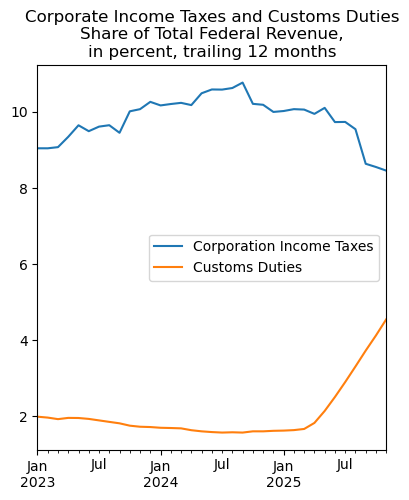

In [4]:
# Calculate the share of total
c = ['Corporation Income Taxes', 'Customs Duties']
res = (data[c].divide(data['Total'], axis=0) * 100)
res.index.name = ''
res.columns.name = ''

title = ('Corporate Income Taxes and Customs Duties\n'+
         'Share of Total Federal Revenue,\n'+
         'in percent, trailing 12 months')
res.loc['2023-01-01':].plot(title=title, figsize=(4.5,5));